In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Para a primeira questao vamos criar o modelo de configuraçao modal

In [53]:
def confmod(k):
    if sum(k)%2 != 0:
        return "erro"
    n = []
    G = nx.MultiGraph()
    s = list(range(len(k)))
    d = dict()
    c = 0
    for i in s:
        d[i] = k[i]      
    while sum(d.values())>0:
        c += 1
        a,b = np.random.choice(s,2)
        if d[a] > 0 and d[b] >0:
            n.append((a,b))
            d[a] -= 1
            if a != b:
                d[b] -= 1
        if d[a] <= 0:
            s.remove(a)
        if d[b] <= 0 and a != b:
            s.remove(b)      
    G.add_edges_from(n)
    return G

segundo, vamos construir uma sequencia de nós que segue uma lei de potencia:

In [119]:
def leidepot(n,m,a,z = 2):
    s = 0
    while abs(np.mean(s)-m) > 0.2:
        s = []
        while len(s) < n:
            l = int(nx.utils.powerlaw_sequence(1,a)[0] + m*(a/(a+1))-z)
            s.append(l)
        if sum(s)%2 != 0:
            s[0] += 1
        
    return s

ex 1:

In [51]:
K1 = leidepot(1000,1,2.5)
K2 = leidepot(1000,2,2.5)
K3 = leidepot(1000,10,2.5)

In [54]:
G1 = confmod(K1)
G2 = confmod(K2)
G3 = confmod(K3)

Para G1:

 Grau max: 99 
 Diametro:  11


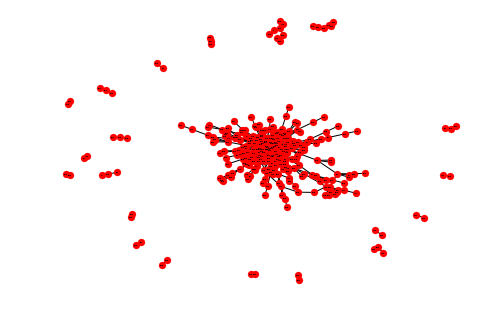

In [91]:
nx.draw(G1, with_labels=True, font_weight='bold', node_size = 50, font_size = 2, linewidths = 0.2, width = 1)
print(" Grau max:",max(dict(G1.degree()).values()),"\n" ,"Diametro: ",
nx.diameter(max(nx.connected_component_subgraphs(G1), key=len)))

parâmetros: α = 2.5 e k medio = 1

com os resultados matematicos esperamos que esta rede tenha grau maximo igual a 100 e diamentro igual a 2

 Grau max: 277 
 Diametro:  12


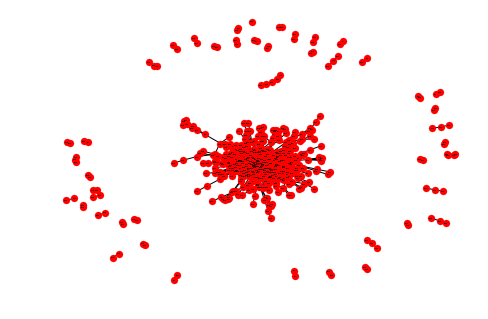

In [92]:
nx.draw(G2, with_labels=True, font_weight='bold', node_size = 50, font_size = 2, linewidths = 0.2, width = 1)
print(" Grau max:",max(dict(G2.degree()).values()),"\n" ,"Diametro: ",
nx.diameter(max(nx.connected_component_subgraphs(G2), key=len)))

parâmetros: α = 2.5 e k medio = 2

com os resultados matematicos esperamos que esta rede tenha grau maximo igual a 100 e diamentro igual a 2

 Grau max: 4874 
 Diametro:  6


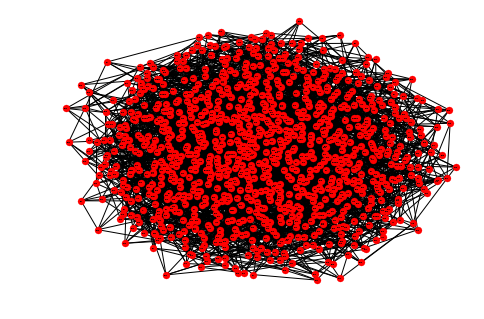

In [93]:
nx.draw(G3, with_labels=True, font_weight='bold', node_size = 50, font_size = 2, linewidths = 0.2, width = 1)
print(" Grau max:",max(dict(G3.degree()).values()),"\n" ,"Diametro: ",
nx.diameter(max(nx.connected_component_subgraphs(G3), key=len)))

parâmetros: α = 2.5 e k medio = 10

com os resultados matematicos esperamos que esta rede tenha grau maximo igual a 600 e diamentro igual a 2

agora iremos criar uma funcao que vai ser responsavel por infectar nós iniciais

In [127]:
def infectados(n,ni):
    if ni > n:
        return "erro"
    p = np.zeros(n, dtype = int)
    i = np.ones(ni, dtype = int)
    escolidos = []
    for k in i:
        z = np.random.randint(n)
        while z in escolidos:
            z = np.random.randint(n)
        escolidos.append(z)
        p[z] = k
    return p

em seguida faremos uma funcão que imuniza (==retira da rede) n nós, teremos 3 funcoes pra isso cada uma preocupada em retirar os nós da rede com um criterio especifico

In [129]:
def aleatorio(G,i):
    A = G.copy()
    l = list(A.nodes)
    k = np.random.choice(l,size = i, replace=False)
    A.remove_nodes_from(k)
    return(A)


In [130]:
def hubs(G,i):
    A = G.copy()
    n = []
    for k in range(i):
        s = [a for a,b in list(A.degree()) if b == max(dict(A.degree()).values())][0]
        A.remove_node(s)
    return A

In [131]:
def vizinhos(G,i):
    A = G.copy()
    m = set()
    while len(m) < i:
        s = np.random.choice(list(A.nodes()))
        v = list(A.neighbors(s))
        k = np.random.choice(v)
        m.add(k)
    m = list(m)
    A.remove_nodes_from(m)
    
    return A

o motor que espalhara a epidemia sera dado por:

In [175]:
def infecao(G,b,h,i,n = 0,f = None,retorno = "infectados"):
    if f != None:
        G = nx.Graph(nx.adjacency_matrix(f(G,n)))
    H = G.copy()
    G = np.array(nx.adjacency_matrix(G).todense())
    i = infectados(len(G),i)
    c = []
    for l in range(200):
        for x,y in enumerate(i):
            if i[x] == 1 and np.random.rand(1) < h:
                i[x] = 0
            for w in H.neighbors(x):
                if i[w] == 1 and np.random.rand(1) < b:
                    i[x] = 1
        c.append(sum(i))
    if retorno == "infectados":
        return c[-1]
    else:
        return plt.scatter(np.linspace(0,100,200),c)  

vamos nos preocupar em simular a imunizacao da rede, para isso criamos as seguintes funcoes: 

teste- ela testara quantos nós precisamos imunizar para cada um dos metodos.

superteste- chamara teste n vezes e dara uma descricão completa

In [170]:
def teste(G,s):
    c = []
    for x in [aleatorio, vizinhos, hubs]:
        t = True
        n = s-1
        while t == True:
            n += 1
            k = infecao(G,0.01,0.1,5,n,x)
            if k == 0:
                t = False
        c.append(n)
        
    return np.array(c)
    

def superteste(G,m,n):
    z = []
    for x in range(m):
        c = teste(G,n)
        z.append(c)
    a = pd.DataFrame(data = z,columns = ["aleatorio","vizinhos","hubs"])
    print("aleatorio : \n")
    print("media e variancia :", (a["aleatorio"].mean(),a["aleatorio"].var()),"\n")
    print("vizinhos : \n")
    print("media e variancia :", (a["vizinhos"].mean(),a["vizinhos"].var()),"\n")
    print("hubs : \n")
    print("media e variancia :", (a["hubs"].mean(),a["hubs"].var()),"\n")
    return a

ex 2:

In [95]:
H1 = nx.erdos_renyi_graph(10000,20/(10000-1))

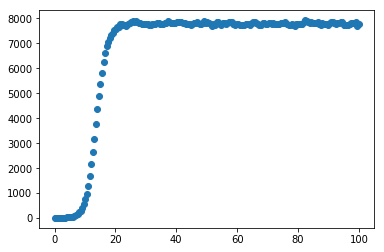

In [102]:
infecao(H1,0.02,0.1,5)

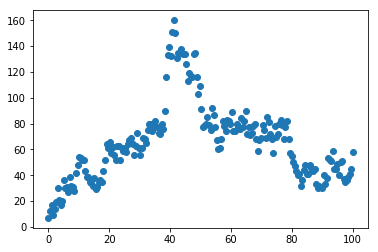

In [103]:
infecao(H1,0.02,0.4,5)

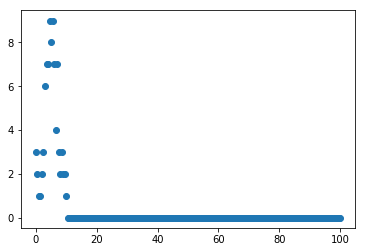

In [104]:
infecao(H1,0.02,0.5,5)

In [120]:
L1 = leidepot(10000,20,2.5,-3)

In [122]:
H2 = confmod(L1)

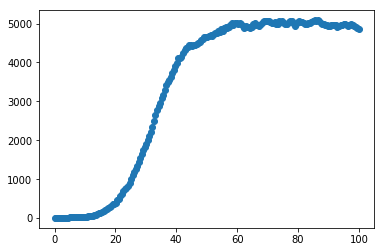

In [141]:
infecao(H2,0.01,0.1,5)

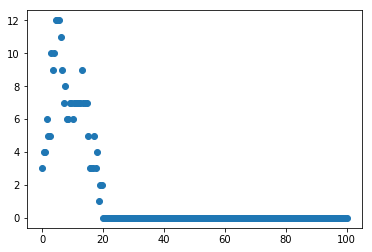

In [142]:
infecao(H2,0.01,0.2,5)

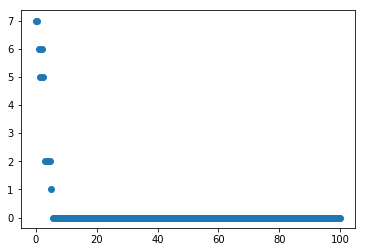

In [143]:
infecao(H1,0.01,0.3,5)